<a href="https://colab.research.google.com/github/usef-kh/EC523-Deep-Learning-Project/blob/master/FER_with_CNN_Ensemble_optimized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
!git clone "https://github.com/usef-kh/EC523-Deep-Learning-Project.git"

fatal: destination path 'EC523-Deep-Learning-Project' already exists and is not an empty directory.


In [6]:
!pip install unrar

In [2]:
# !unrar x "EC523-Deep-Learning-Project/datasets/ckplus.rar"
!unrar e "EC523-Deep-Learning-Project/datasets/fer2013.rar"


UNRAR 5.50 freeware      Copyright (c) 1993-2017 Alexander Roshal


Extracting from EC523-Deep-Learning-Project/datasets/fer2013.rar


Would you like to replace the existing file fer2013.csv
301108654 bytes, modified on 2020-10-14 22:59
with a new one
301108654 bytes, modified on 2020-10-14 22:59

[Y]es, [N]o, [A]ll, n[E]ver, [R]ename, [Q]uit Yes

Extracting  fer2013.csv                                                    4%  9% 13% 18% 23% 27% 32% 37% 41% 46% 51% 55% 60% 65% 69% 74% 79% 83% 88% 93% 97% 99%  OK 
All OK


##Imports

In [3]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

##Load Dataset

In [4]:
fer2013 = pd.read_csv('fer2013.csv') 
emotions = {0: 'Angry', 1: 'Disgust', 2: 'Fear', 3: 'Happy', 4: 'Sad', 5: 'Surprise', 6: 'Neutral'}
fer2013.head()

transform = transforms.Normalize(mean=129.4456, std = 1)

def prepare_data(data):
    """ Prepare data for modeling 
        input: data frame with labels und pixel data
        output: image and label array """
    
    image_array = np.zeros(shape=(len(data), 48, 48))
    image_label = np.array(list(map(int, data['emotion'])))
    
    for i, row in enumerate(data.index):
        image = np.fromstring(data.loc[row, 'pixels'], dtype=int, sep=' ')
        image = np.reshape(image, (48, 48))
        image_array[i] = image
        
    return image_array, image_label

xtrain, ytrain = prepare_data(fer2013[fer2013['Usage'] == 'Training'])
xval , yval = prepare_data(fer2013[fer2013['Usage'] == 'PrivateTest'])
xtest, ytest = prepare_data(fer2013[fer2013['Usage'] == 'PublicTest'])

In [5]:
class Fer2013(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform        
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx]).type(torch.long)
        sample = (img, label)
        
        return sample

mu, st = 0, 255
train_transform = transforms.Compose([
                    transforms.RandomResizedCrop(48, scale=(0.8, 1.0)),
                    transforms.RandomAffine(0, translate=(0, 0.1)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(10),
                    transforms.ToTensor(),
                    transforms.Normalize(mean=mu, std = st)
                    ])

test_transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize(mean=mu, std = st)
                    ])

train = Fer2013(xtrain, ytrain, train_transform)
val = Fer2013(xval, yval, test_transform)
test = Fer2013(xtest, ytest, test_transform)

In [6]:
trainloader = torch.utils.data.DataLoader(train, batch_size=100, shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val, batch_size=100, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(test, batch_size=100, shuffle=True, num_workers=2)

Batch Images Shape: torch.Size([100, 1, 48, 48])
Batch Labels Shape: torch.Size([100])

   Fear Neutral   Angry     Sad   Happy


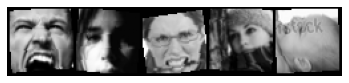

In [8]:
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), cmap='gray')

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print("Batch Images Shape:", images.shape)
print("Batch Labels Shape:", labels.shape)
print()

# show 5 images
imshow(torchvision.utils.make_grid(images[:5]))
plt.axis('off')
# print labels
print(' '.join('%7s' % emotions[labels[j].item()] for j in range(5)))

##Model

In [9]:
class History:
    def __init__(self):
        self.loss_train = []
        self.loss_val = []

        self.acc_train = []
        self.acc_val = []

### Subnets

In [10]:
class Subnet1(nn.Module):
    def __init__(self):
        super(Subnet1, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)

        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        
        self.lin1 = nn.Linear(256*6*6, 4096) 
        self.lin2 = nn.Linear(4096, 4096)
        self.lin3 = nn.Linear(4096, 7)

        self.drop = nn.Dropout(0.1)

        self.bn1 = nn.BatchNorm2d(64)
        self.bn2 = nn.BatchNorm2d(128)
        self.bn3 = nn.BatchNorm2d(256)

        self.history = History()


    def forward(self, x):
        # x = F.relu(self.conv1(x))
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.drop(x)
        x = self.pool(x)

        # x = F.relu(self.conv2(x))
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.drop(x)
        x = self.pool(x)

        # x = F.relu(self.conv3(x))
        # x = self.bn3(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.drop(x)
        x = self.pool(x)

        x = x.view(-1, 256*6*6) 
        
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        
        x = self.lin3(x)

        return x

In [ ]:
class Subnet2(nn.Module):
    def __init__(self):
        super(Subnet2, self).__init__()
        # Not sure about number of in channels, may have to change!
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1) # according to paper!
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(64,128,3,padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_2 = nn.Conv2d(256,256, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features= 64)
        self.bn2 = nn.BatchNorm2d(num_features= 128)
        self.bn3 = nn.BatchNorm2d(num_features= 256)
        self.lin1 = nn.Linear(256 * 6 * 6, 4096) # MUST CHANGE
        self.lin2 = nn.Linear(4096, 4096)
        self.lin3 = nn.Linear(4096, 7)

        self.history = History()
        
        #self.drop = nn.Dropout(0.2)

    def forward(self, x):

        x = F.relu(self.bn1(self.conv1(x)))
        #print("shape after 1 conv layer: ", x.shape)
        x = self.pool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        #print("shape after 2 conv layer: ", x.shape)
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.bn3(self.conv3_2(x)))
        #print("shape after 3 conv layer: ", x.shape)
        x = self.pool(x)
        #print("shape before linear layers!!: ", x.shape)
        x = x.view(x.size(0), 256 * 6 * 6)

        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)

        return x

In [ ]:
class Subnet3(nn.Module):
    def __init__(self):
        super(Subnet3, self).__init__()
        # Not sure about number of in channels, may have to change!

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, padding=1) # according to paper!
        self.pool = nn.MaxPool2d(kernel_size=2,stride=2)
        self.conv2 = nn.Conv2d(64,128,3,padding=1)
        self.conv2_2 = nn.Conv2d(128,128,3,padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv3_2 = nn.Conv2d(256,256, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(num_features= 64)
        self.bn2 = nn.BatchNorm2d(num_features= 128)
        self.bn3 = nn.BatchNorm2d(num_features= 256)
        self.lin1 = nn.Linear(256 * 6 * 6, 4096) # MUST CHANGE
        self.lin2 = nn.Linear(4096, 4096)
        self.lin3 = nn.Linear(4096, 7)

        self.history = History()
        
    def forward(self, x):

        x = F.relu(self.bn1(self.conv1(x)))
        #print("shape after 1 conv layer: ", x.shape)
        x = self.pool(x)

        x = F.relu(self.conv2(x))
        x = F.relu(self.bn2(self.conv2_2(x)))
        #print("shape after 2 conv layer: ", x.shape)
        x = self.pool(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.bn3(self.conv3_2(x)))
        #print("shape after 3 conv layer: ", x.shape)
        x = self.pool(x)

        x = x.view(-1, 256*6*6) # CHANGE
      
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)

        return x

### Ensemble

##Training

In [11]:
def train_model(net, trainloader, valloader, n_epochs=20):

    for epoch in range(n_epochs):
        
        net = net.train()
        loss_tr, correct_count, n = 0.0, 0.0, 0.0
        for i, data in enumerate(trainloader):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            
            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # calculate performance metrics
            loss_tr += loss.item()
            
            _, preds = torch.max(outputs.data, 1)
            correct_count += (preds == labels).sum().item()
            n += labels.size(0)
            
        # Save train and validation performance metrics 
        acc_tr = 100 * correct_count / n
        loss_tr = loss_tr / n

        acc_v, loss_v = test_model(net, valloader)

        net.history.loss_train.append(loss_tr)
        net.history.loss_val.append(loss_v)

        net.history.acc_train.append(acc_tr)
        net.history.acc_val.append(acc_v)
        
        print('Epoch %2d' % (epoch + 1), 'Train Accuracy: %2.2f %%' % (acc_tr), 'Val Accuracy: %2.2f %%' % (acc_v), sep='\t\t')

In [12]:
def test_model(net, dataloader):
    
    net = net.eval()

    loss, correct_count, n_sampels = 0.0, 0.0, 0.0
    for data in dataloader:

        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = net(inputs)

        loss += criterion(outputs, labels).item()

        _, preds = torch.max(outputs.data, 1)
        correct_count += (preds == labels).sum().item()
        n_sampels += labels.size(0)
    
    acc = 100 * correct_count / n_sampels
    loss = loss / n_sampels
    
    return acc, loss

In [13]:
sub1 = Subnet1()
sub1 = sub1.to(device)

In [ ]:
# sub2 = Subnet2()
# sub2 = sub2.to(device)

In [ ]:
# sub3 = Subnet3()
# sub3 = sub3.to(device)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(sub1.parameters(), lr=0.01, momentum=0.9)
train_model(sub1, trainloader, valloader, n_epochs=100)

Epoch  1		Train Accuracy: 32.89 %		Val Accuracy: 41.10 %
Epoch  2		Train Accuracy: 40.50 %		Val Accuracy: 45.97 %
Epoch  3		Train Accuracy: 44.54 %		Val Accuracy: 40.54 %
Epoch  4		Train Accuracy: 47.12 %		Val Accuracy: 46.98 %
Epoch  5		Train Accuracy: 48.83 %		Val Accuracy: 53.05 %
Epoch  6		Train Accuracy: 50.53 %		Val Accuracy: 55.31 %
Epoch  7		Train Accuracy: 51.99 %		Val Accuracy: 53.61 %
Epoch  8		Train Accuracy: 53.34 %		Val Accuracy: 56.78 %
Epoch  9		Train Accuracy: 53.98 %		Val Accuracy: 54.44 %
Epoch 10		Train Accuracy: 55.32 %		Val Accuracy: 58.01 %
Epoch 11		Train Accuracy: 55.67 %		Val Accuracy: 56.37 %
Epoch 12		Train Accuracy: 56.51 %		Val Accuracy: 55.34 %
Epoch 13		Train Accuracy: 57.35 %		Val Accuracy: 57.73 %
Epoch 14		Train Accuracy: 58.17 %		Val Accuracy: 57.98 %
Epoch 15		Train Accuracy: 58.00 %		Val Accuracy: 53.78 %
Epoch 16		Train Accuracy: 58.89 %		Val Accuracy: 58.43 %
Epoch 17		Train Accuracy: 59.38 %		Val Accuracy: 60.85 %
Epoch 18		Train Accuracy: 60.35

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(sub1.parameters(), lr=0.001, momentum=0.9)
train_model(sub1, trainloader, valloader, n_epochs=20)

Epoch  1		Train Accuracy: 98.72 %		Val Accuracy: 68.01 %
Epoch  2		Train Accuracy: 98.69 %		Val Accuracy: 68.01 %
Epoch  3		Train Accuracy: 98.81 %		Val Accuracy: 68.07 %
Epoch  4		Train Accuracy: 98.81 %		Val Accuracy: 68.29 %
Epoch  5		Train Accuracy: 98.84 %		Val Accuracy: 68.35 %
Epoch  6		Train Accuracy: 98.72 %		Val Accuracy: 68.29 %
Epoch  7		Train Accuracy: 98.77 %		Val Accuracy: 68.24 %
Epoch  8		Train Accuracy: 98.79 %		Val Accuracy: 68.07 %
Epoch  9		Train Accuracy: 98.75 %		Val Accuracy: 68.10 %
Epoch 10		Train Accuracy: 98.78 %		Val Accuracy: 67.71 %
Epoch 11		Train Accuracy: 98.81 %		Val Accuracy: 68.07 %
Epoch 12		Train Accuracy: 98.83 %		Val Accuracy: 68.12 %
Epoch 13		Train Accuracy: 98.89 %		Val Accuracy: 68.21 %
Epoch 14		Train Accuracy: 98.83 %		Val Accuracy: 68.15 %
Epoch 15		Train Accuracy: 98.69 %		Val Accuracy: 68.29 %
Epoch 16		Train Accuracy: 98.83 %		Val Accuracy: 68.29 %
Epoch 17		Train Accuracy: 98.83 %		Val Accuracy: 68.04 %
Epoch 18		Train Accuracy: 98.87

##Evaluation

In [19]:
def plot_metrics(net):
    plt.figure()
    plt.plot(net.history.acc_train, 'g', label='Training Acc')
    plt.plot(net.history.acc_val, 'b', label='Validation Acc')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Acc')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure()
    plt.plot(net.history.loss_train, 'g', label='Training Loss')
    plt.plot(net.history.loss_val, 'b', label='Validation Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

    print('Training Accuracy: %2.2f %%' % (max(net.history.acc_train)))
    print('Validation Accuracy: %2.2f %%' % (max(net.history.acc_val)))
    print()

    acc, loss = test_model(net, testloader)    
    print('Test Accuracy: %2.2f %%' % (acc))
    print('Average Test Loss: %2.4f' % (loss))
    

### Subnets

Subnet 1


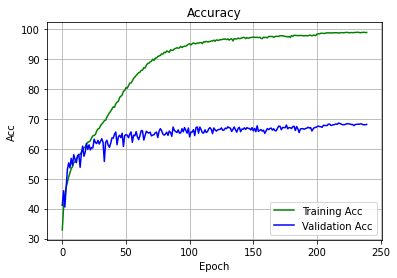

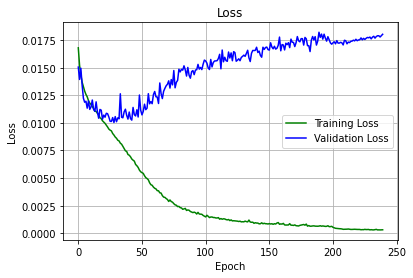

Training Accuracy: 98.89 %
Validation Accuracy: 68.57 %

Test Accuracy: 66.65 %
Average Test Loss: 0.0196


In [20]:
print("Subnet 1")
plot_metrics(sub1) 

In [21]:
path = 'sub1_batchnorm_beforeRelu'
torch.save(sub1.state_dict(), path)

Subnet 2


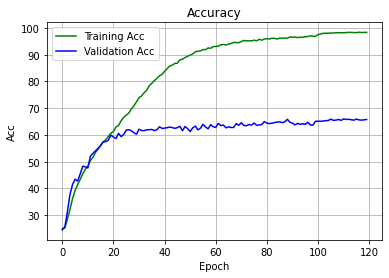

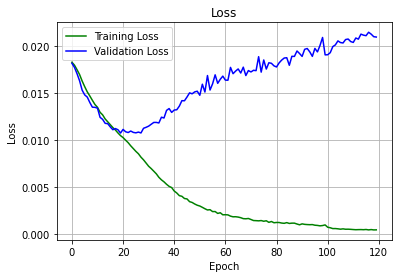

Training Accuracy: 98.39 %
Validation Accuracy: 65.98 %

Test Accuracy: 64.39 %
Average Test Loss: 0.0229


In [ ]:
print("Subnet 2")
plot_metrics(sub2)

Subnet 3


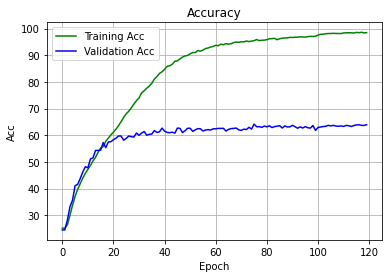

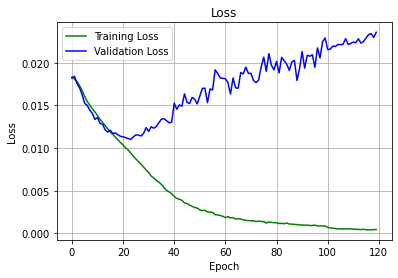

Training Accuracy: 98.61 %
Validation Accuracy: 64.17 %

Test Accuracy: 64.22 %
Average Test Loss: 0.0247


In [ ]:
print("Subnet 3")
plot_metrics(sub3)

##Save Model

In [ ]:
path = 'sub3'
torch.save(sub3.state_dict(), path)

In [ ]:
# from google.colab import files
# files.download(path)